### Boiler Plate Code

In [1]:
import random
import os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import trange
%matplotlib inline

In [3]:
# set up params for plots
SMALL, MED, LARGE, LW = 18, 24, 30, 3
plt.rc('axes', titlesize=SMALL)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('legend', fontsize=MED)   # legend fontsize
plt.rc('font', size=SMALL)       # controls default text sizes

##### Iterated Local Search

We closely follow the paper: ILS for QAP (Sultze '05) to implement the below method

In [4]:
class IteratedLocalSearch:
    def __init__(self, w, d):
        self.W = w
        self.D = d
        self.n = w.shape[0]

    def cost(self, X):
        return np.sum(self.W * self.D[X][:, X])
    
    # Subroutines
    def generate_initial_solution(self):
        return np.random.permutation(self.n)
    
    @staticmethod
    def local_search(perm: np.array):
        n = len(perm)
        curr_best = np.copy(perm)  # create a deep copy
        
        for i in range(1, n-2):
            for j in range(i+1, n):
                
                new_perm = np.copy(curr_best)
                new_perm[i:j] = curr_best[j-1:i-1:-1]
                
                if cost(new_perm, d, w) < cost(curr_best, d, w): 
                    curr_best = new_perm        
        
        return curr_best
    
    @staticmethod
    def acceptance_criterion(perm1: np.array, perm2: np.array):
        return perm1 if cost(perm1, d, w) < cost(perm2, d, w) else perm2
    
    @staticmethod
    def peturbation(perm: np.array, k: int):
        new_perm = perm[:]
        # of course, this inexact method can result in pertubations of size < k, but these occur with sufficiently small probability 
        for _ in range(k): 
            i = random.randint(0, len(perm)-1)
            j = random.randint(0, len(perm)-1)
            new_perm[i], new_perm[j] = new_perm[j], new_perm[i]   
        
        return new_perm
    

    # ILS implementation
    def iterated_local_search(self, n_iters: int, write_to_file=False):
        s0 = self.generate_initial_solution()
        s  = self.local_search(s0)
        
        curr_best = s
        cost_history = [cost(s,d,w)]
        perm_history = [s]
        n = len(s0)

        for _ in trange(n_iters):
            s1 = self.peturbation(s, k=n//2)
            s2 = self.local_search(s1)
            curr_best = self.acceptance_criterion(curr_best, s2)
            
            cost_history.append(cost(curr_best, d, w))
            perm_history.append(curr_best)

        return s, cost_history, perm_history

### Verification

we verify the correctness of our implementation by plotting cost history on the following test instance 

In [5]:
# for managing file opening and closing
def read_integers(filename):
    with open(filename) as f:
        return [int(elem) for elem in f.read().split()]

file_path = '../QAPInstances/tai30b.dat'
file_it = iter(read_integers('../QAPInstances/tai30b.dat'))

# Number of points
n = next(file_it)

# Distance between locations
w = np.array([[next(file_it) for j in range(n)] for i in range(n)])
d = np.array([[next(file_it) for j in range(n)] for i in range(n)])

ils = IteratedLocalSearch(w, d)
soln, cost_hist, perm_hist = ils.iterated_local_search(10_000)

100%|██████████| 10000/10000 [02:25<00:00, 68.54it/s]


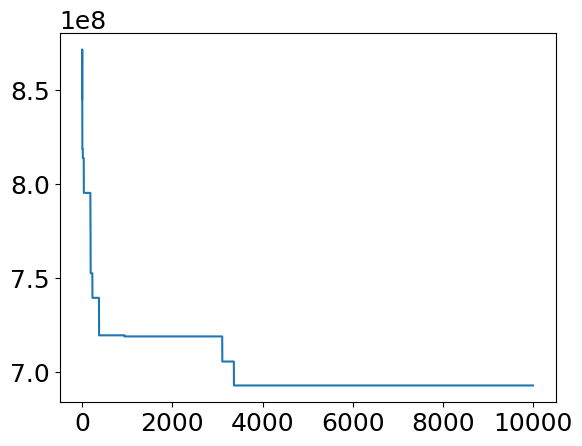

In [6]:
plt.plot(cost_hist)

### Automated Testing
code for automating the opening, closing and testing of a hueristic on every instance in QAPLib

In [52]:
instance_path = '../QAPInstances/'
soln_path     = '../QAPSolns/'

def open_solution(filename: str):
    file_it = iter(read_integers(filename))
    _ = next(file_it)    # this is just how the files within the lib are formatted
    return next(file_it)

        

def test_hueristic():

    for filename in os.listdir(instance_path):
    
        file_it = iter(read_integers(instance_path+filename))

        # open QAP instance param's 
        n = next(file_it)
        w = np.array([[next(file_it) for j in range(n)] for i in range(n)])
        d = np.array([[next(file_it) for j in range(n)] for i in range(n)])

        # generate an instance
        ils = IteratedLocalSearch(w, d)

        # open up corresponding soln from QAPLib: 
        soln_file = filename[:-4]+'.sln' # this removes the .dat from filename
        
        try:
            soln = open_solution(soln_path+soln_file)

        except FileNotFoundError:
            os.remove(instance_path+filename) # any instances without corresponding solution files are deleted

    return